## ADF Diagnostics In Jupyter
This notebook will run the Atmospheric Diagnostic Framework using the settings in a config.yaml file in your ADF directory. 

Note that it was developed to run on Cheyenne/Caspar *with the NPL (conda) kernel*

### Setup
#### Required packages

In [1]:
import os.path
from pathlib import Path
import sys

#### Paths

In [2]:
### default parameters
# adf_path = "./ADF"
# config_path = "."
# config_fil_str = "config_f.cam6_3_119.FLTHIST_ne30.r328_gamma0.33_soae_numcin3.001_vs_f.cam6_3_119.FLTHIST_ne30.r328_gamma0.33_soae.001.yaml"


In [3]:
# cell to insert parameters

#### All path processing:



In [4]:
# Determine ADF directory path
# If it is in your cwd, set adf_path = local_path, 
# otherwise set adf_path appropriately

local_path = os.path.abspath('')

# Set up the ADF for your location/user name
#user = "richling" 
#adf_path = f"/glade/work/{user}/ADF/"

print(f"current working directory = {local_path}")
print(f"ADF path                  = {adf_path}")

current working directory = /glade/u/home/eromashkova/codes/test-combined-diags/nblibrary
ADF path                  = ./ADF


In [5]:
#set path to ADF lib
lib_path = os.path.join(adf_path,"lib")
print(f"The lib scripts live here, right? {lib_path}")

#Add paths to python path:
sys.path.append(lib_path)

The lib scripts live here, right? ./ADF/lib


In [6]:
#set path to ADF plotting scripts directory
plotting_scripts_path = os.path.join(adf_path,"scripts","plotting")
print(f"The plotting scripts live here, right? {plotting_scripts_path}")

#Add paths to python path:
sys.path.append(plotting_scripts_path)

The plotting scripts live here, right? ./ADF/scripts/plotting


#### Import config file into ADF object
If there are errors, here, it is likely due to path errors above

In [7]:
config_file=os.path.join(config_path,config_fil_str)


In [8]:
#import ADF diagnostics object
from adf_diag import AdfDiag

# If this fails, check your paths output in the cells above,
# and that you are running the NPL (conda) Kernel
# You can see all the paths being examined by un-commenting the following:
#sys.path

In [9]:
#Initialize ADF object
adf = AdfDiag(config_file)
adf

### ADF Standard Work Flow

#### Calculate the Time Series files

* NOTE: If <strong>not</strong> comparing against observations, you must run <strong>_create_time_series()_</strong> again with baseline flag

In [10]:
#Create model time series.
adf.create_time_series()

#Create model baseline time series (if needed):
if not adf.compare_obs:
    adf.create_time_series(baseline=True)


  Generating CAM time series files...
	 Processing time series for case 'f.cam6_3_119.FLTHIST_ne30.r328_gamma0.33_soae_numcin3.001' :
  ...CAM time series file generation has finished successfully.

  Generating CAM time series files...
	 Processing time series for case 'f.cam6_3_119.FLTHIST_ne30.r328_gamma0.33_soae.001' :
  ...CAM time series file generation has finished successfully.


#### Calculate the Climo files

* NOTE: <strong>Do not</strong> need to specify or repeat for baseline case unlike time series generation

In [11]:
#Create model climatology (climo) files.
adf.create_climo()


  Calculating CAM climatologies...
	 Calculating climatologies for case 'f.cam6_3_119.FLTHIST_ne30.r328_gamma0.33_soae_numcin3.001' :
	    INFO: Found climo file and clobber is False, so skipping AODDUSTdn and moving to next variable.
	    INFO: Found climo file and clobber is False, so skipping AODDUST and moving to next variable.
	    INFO: Found climo file and clobber is False, so skipping AODVIS and moving to next variable.
	    INFO: Found climo file and clobber is False, so skipping CLDHGH and moving to next variable.
	    INFO: Found climo file and clobber is False, so skipping CLDICE and moving to next variable.
	    INFO: Found climo file and clobber is False, so skipping CLDLIQ and moving to next variable.
	    INFO: Found climo file and clobber is False, so skipping CLDLOW and moving to next variable.
	    INFO: Found climo file and clobber is False, so skipping CLDMED and moving to next variable.
	    INFO: Found climo file and clobber is False, so skipping CLDTOT and movi

Time series files for variable 'TROP_T' not found.  Script will continue to next variable.


	 Calculating climatologies for case 'f.cam6_3_119.FLTHIST_ne30.r328_gamma0.33_soae.001' :
The input location searched was: /glade/scratch/richling/adf-output/ADF-data/timeseries/f.cam6_3_119.FLTHIST_ne30.r328_gamma0.33_soae.001/1995-2005. The glob pattern was f.cam6_3_119.FLTHIST_ne30.r328_gamma0.33_soae.001*.AODDUSTdn.*nc.
	    INFO: Found climo file and clobber is False, so skipping AODDUST and moving to next variable.
	    INFO: Found climo file and clobber is False, so skipping AODVIS and moving to next variable.
	    INFO: Found climo file and clobber is False, so skipping CLDHGH and moving to next variable.
	    INFO: Found climo file and clobber is False, so skipping CLDICE and moving to next variable.
	    INFO: Found climo file and clobber is False, so skipping CLDLIQ and moving to next variable.
	    INFO: Found climo file and clobber is False, so skipping CLDLOW and moving to next variable.
	    INFO: Found climo file and clobber is False, so skipping CLDMED and moving to n

Time series files for variable 'AODDUSTdn' not found.  Script will continue to next variable.


  ...CAM climatologies have been calculated successfully.

  Generating CAM TEM diagnostics files...
	 Processing TEM for case 'f.cam6_3_119.FLTHIST_ne30.r328_gamma0.33_soae_numcin3.001' :
	    INFO: Found TEM file and clobber is False, so moving to next case.
	 Processing TEM for case 'f.cam6_3_119.FLTHIST_ne30.r328_gamma0.33_soae.001' :
	    INFO: Found TEM file and clobber is False, so moving to next case.
  ...TEM variables have been calculated successfully.


#### Regrid the Climo files

In [12]:
#Regrid model climatology files to match either
#observations or CAM baseline climatologies.
#This call uses the "regridding_scripts" specified in the config file:
adf.regrid_climo()


  Regridding CAM climatologies...
	 Regridding case 'f.cam6_3_119.FLTHIST_ne30.r328_gamma0.33_soae_numcin3.001' :
	 - regridding PS (known targets: ['f.cam6_3_119.FLTHIST_ne30.r328_gamma0.33_soae.001'])
	 Regridded file already exists, so skipping...
	 - regridding LANDFRAC (known targets: ['f.cam6_3_119.FLTHIST_ne30.r328_gamma0.33_soae.001'])
	 Regridded file already exists, so skipping...
	 - regridding OCNFRAC (known targets: ['f.cam6_3_119.FLTHIST_ne30.r328_gamma0.33_soae.001'])
	 Regridded file already exists, so skipping...
	 - regridding AODDUSTdn (known targets: ['f.cam6_3_119.FLTHIST_ne30.r328_gamma0.33_soae.001'])
	 - regridding AODDUSTdn failed, no file. Continuing to next variable.
	 - regridding AODDUST (known targets: ['f.cam6_3_119.FLTHIST_ne30.r328_gamma0.33_soae.001'])
	 Regridded file already exists, so skipping...
	 - regridding AODVIS (known targets: ['f.cam6_3_119.FLTHIST_ne30.r328_gamma0.33_soae.001'])
	 Regridded file already exists, so skipping...
	 - regriddin

#### Run statistics on Time Series files

#Perform analyses on the simulation(s).
#This call uses the "analysis_scripts" specified in the config file:
adf.perform_analyses()

#### Create Plots

#Create plots.
#This call uses the "plotting_scripts" specified in the config file:
adf.create_plots()


#### Generate HTML files

* This will create html files that you can view via webbrower either:
    - in Casper/Cheyenne
    - pushing it to CGD projects webpage through Tungsten

#Create website.
if adf.create_html:
    adf.create_website()

---

## ADF Helpful Methods and Structures 

Demonstration of a few methods to get information from the ADF object

#### List all adf object related methods

In [13]:
dir(adf)

['_AdfBase__debug_log',
 '_AdfConfig__config_dict',
 '_AdfConfig__create_search_dict',
 '_AdfConfig__expand_yaml_var_ref',
 '_AdfConfig__kword_pattern',
 '_AdfConfig__search_dict',
 '_AdfDiag__analysis_scripts',
 '_AdfDiag__cvdp_info',
 '_AdfDiag__diag_scripts_caller',
 '_AdfDiag__function_caller',
 '_AdfDiag__plotting_scripts',
 '_AdfDiag__regridding_scripts',
 '_AdfDiag__time_averaging_scripts',
 '_AdfInfo__base_nickname',
 '_AdfInfo__basic_info',
 '_AdfInfo__cam_bl_climo_info',
 '_AdfInfo__cam_climo_info',
 '_AdfInfo__compare_obs',
 '_AdfInfo__diag_var_list',
 '_AdfInfo__eyear_baseline',
 '_AdfInfo__eyears',
 '_AdfInfo__num_cases',
 '_AdfInfo__num_procs',
 '_AdfInfo__plot_location',
 '_AdfInfo__syear_baseline',
 '_AdfInfo__syears',
 '_AdfInfo__test_nicknames',
 '_AdfObs__var_obs_dict',
 '_AdfObs__variable_defaults',
 '_AdfWeb__case_web_paths',
 '_AdfWeb__plot_type_multi',
 '_AdfWeb__plot_type_order',
 '_AdfWeb__website_data',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '

In [14]:
adf.num_procs

8

### Get information from the subsections of the config yaml file

Remember the different sub-sections?

#### Basic Info Section

In [15]:
basic_info_dict = adf.read_config_var("diag_basic_info")

for key,val in basic_info_dict.items():
    print(f"{key}: {val}")

compare_obs: False
hist_str: cam.h0
create_html: True
obs_data_loc: /glade/work/nusbaume/SE_projects/model_diagnostics/ADF_obs
cam_regrid_loc: ${diag_loc}regrid/
cam_overwrite_regrid: False
cam_diag_plot_loc: ${diag_loc}diag-plot/
use_defaults: True
plot_press_levels: [200, 850]
weight_season: True
num_procs: 8
redo_plot: False


#### Test Case Info Section

In [16]:
test_dict = adf.read_config_var("diag_cam_climo")

for key,val in test_dict.items():
    print(f"{key}: {val}")

calc_cam_climo: True
cam_overwrite_climo: False
cam_case_name: f.cam6_3_119.FLTHIST_ne30.r328_gamma0.33_soae_numcin3.001
cam_hist_loc: /glade/derecho/scratch/hannay/archive/${diag_cam_climo.cam_case_name}/atm/hist/
yrs: ${diag_cam_climo.start_year}-${diag_cam_climo.end_year}
cam_climo_loc: ${climo_loc}${diag_cam_climo.cam_case_name}/${diag_cam_climo.yrs}/
start_year: 1995
end_year: 2005
cam_ts_done: False
cam_ts_save: True
cam_overwrite_ts: False
cam_ts_loc: ${ts_loc}${diag_cam_climo.cam_case_name}/${diag_cam_climo.yrs}/
case_nickname: ${diag_cam_climo.cam_case_name}


#### Baseline Case Info Section

In [17]:
baseline_dict = adf.read_config_var("diag_cam_baseline_climo")

for key,val in baseline_dict.items():
    print(f"{key}: {val}")

calc_cam_climo: True
cam_overwrite_climo: False
cam_case_name: f.cam6_3_119.FLTHIST_ne30.r328_gamma0.33_soae.001
cam_hist_loc: /glade/derecho/scratch/hannay/archive/${diag_cam_baseline_climo.cam_case_name}/atm/hist/
yrs: ${diag_cam_baseline_climo.start_year}-${diag_cam_baseline_climo.end_year}
cam_climo_loc: ${climo_loc}${diag_cam_baseline_climo.cam_case_name}/${diag_cam_baseline_climo.yrs}/
start_year: 1995
end_year: 2005
cam_ts_done: False
cam_ts_save: True
cam_overwrite_ts: False
cam_ts_loc: ${ts_loc}${diag_cam_baseline_climo.cam_case_name}/${diag_cam_baseline_climo.yrs}/
case_nickname: ${diag_cam_baseline_climo.cam_case_name}


### Get information <strong>not directly</strong> from the subsections of the config yaml file

This just represents a different way to get some ADF info

#### Get Case/Baseline Names

This is a different wat to get case names than from the *adf.read_config_var()* method that read in data from sub-sections above

In [18]:
#List of case names (list by default)
case_names = adf.get_cam_info("cam_case_name",required=True)
print(case_names)

base_name = adf.get_baseline_info("cam_case_name")
print(base_name)

['f.cam6_3_119.FLTHIST_ne30.r328_gamma0.33_soae_numcin3.001']
f.cam6_3_119.FLTHIST_ne30.r328_gamma0.33_soae.001


#### Get Case/Baseline Climo file locations

Here we are calling directly from the config file, no subsection 

In [19]:
case_climo_loc = adf.get_cam_info('cam_climo_loc', required=True)
base_climo_loc = adf.get_baseline_info("cam_climo_loc")
case_climo_loc,base_climo_loc

(['/glade/scratch/richling/adf-output/ADF-data/climos/f.cam6_3_119.FLTHIST_ne30.r328_gamma0.33_soae_numcin3.001/1995-2005/'],
 '/glade/scratch/richling/adf-output/ADF-data/climos/f.cam6_3_119.FLTHIST_ne30.r328_gamma0.33_soae.001/1995-2005/')

#### Get Desired Variable Names

Here we are calling directly from the config file, no subsection 

In [20]:
var_list = adf.diag_var_list
print(var_list)

['AODDUSTdn', 'AODDUST', 'AODVIS', 'CLDHGH', 'CLDICE', 'CLDLIQ', 'CLDLOW', 'CLDMED', 'CLDTOT', 'CLOUD', 'FLNS', 'FLNT', 'FLNTC', 'FSNS', 'FSNT', 'FSNTC', 'LHFLX', 'LWCF', 'OMEGA500', 'PBLH', 'PRECL', 'PRECT', 'PRECSL', 'PRECSC', 'PRECSC', 'PRECC', 'PS', 'PSL', 'QFLX', 'Q', 'RELHUM', 'SHFLX', 'SST', 'SWCF', 'T', 'TAUX', 'TAUY', 'TGCLDIWP', 'TGCLDLWP', 'TMQ', 'TREFHT', 'TROP_T', 'TS', 'U', 'U10', 'ICEFRAC', 'OCNFRAC', 'LANDFRAC']


#### Get variable defaults from adf_variable_defaults.yaml

Take a look at what defaults are for <strong>TS</strong>

In [21]:
adf.variable_defaults["TS"]

{'colormap': 'Blues',
 'contour_levels_range': [220, 320, 5],
 'diff_colormap': 'BrBG',
 'diff_contour_range': [-10, 10, 1],
 'scale_factor': 1,
 'add_offset': 0,
 'new_unit': 'K',
 'mpl': {'colorbar': {'label': 'K'}},
 'obs_file': 'ERAI_all_climo.nc',
 'obs_name': 'ERAI',
 'obs_var_name': 'TS',
 'category': 'Surface variables'}

---

## Exploration of the Output Data

Now that the ADF has created all the necessary timeseries/climo/regridded data let's run a quick set of functions to plot time series for RESTOM, TS, and ICEFRAC

##### Let's grab the case names, time series locations, variable defaults dictionary and climo years

In [22]:
case_names = adf.get_cam_info('cam_case_name', required=True)
case_names_len = len(case_names)
data_name = adf.get_baseline_info('cam_case_name', required=False)

case_ts_locs = adf.get_cam_info("cam_ts_loc", required=True)
data_ts_loc = adf.get_baseline_info("cam_ts_loc", required=False)

res = adf.variable_defaults # dict of variable-specific plot preferences
# or an empty dictionary if use_defaults was not specified in YAML.

start_year = adf.climo_yrs["syears"]
end_year = adf.climo_yrs["eyears"]

### Time Series Plotting Functions

In [23]:
def _load_dataset(fils):
    if len(fils) == 0:
        print("Input file list is empty.")
        return None
    elif len(fils) > 1:
        return xr.open_mfdataset(fils, combine='by_coords')
    else:
        sfil = str(fils[0])
        return xr.open_dataset(sfil)
    #End if
#End def

In [24]:
def _data_calcs(ts_loc,var,subset=None):
    """
    args
    ----
     - ts_loc: Path
         path to time series file
         
     - var: str
         name of variable
         
     - subset (optional): dict 
         lat/lon extents (south, north, east, west)
    """
    fils = sorted(list(Path(ts_loc).glob(f"*{var}*.nc")))

    ts_ds = _load_dataset(fils)
    
    time = ts_ds['time']
    time = xr.DataArray(ts_ds['time_bnds'].load().mean(dim='nbnd').values, dims=time.dims, attrs=time.attrs)
    ts_ds['time'] = time
    ts_ds.assign_coords(time=time)
    ts_ds = xr.decode_cf(ts_ds)
    
    if subset != None:
        ts_ds = ts_ds.sel(lat=slice(subset["s"],subset["n"]), lon=slice(subset["w"],subset["e"])) 
    
    data = ts_ds[var].squeeze()
    unit = data.units
    
    # global weighting
    w = np.cos(np.radians(data.lat))
    avg = data.weighted(w).mean(dim=("lat","lon"))
    
    yrs = np.unique([str(val.item().timetuple().tm_year).zfill(4) for _,val in enumerate(ts_ds["time"])])

    return avg,yrs,unit

In [25]:
def ts_plot(ax, name, vals, yrs, unit, color_dict,linewidth=None,zorder=1):
    """
    args
    ----
     - color_dict: dict
         color and marker style for variable
    """

    ax.plot(yrs, vals, color_dict["marker"], c=color_dict["color"],label=name,linewidth=linewidth,zorder=zorder)

    ax.set_xlabel("Years",fontsize=15,labelpad=20)
    ax.set_ylabel(unit,fontsize=15,labelpad=20)  

    # For the minor ticks, use no labels; default NullFormatter.
    ax.tick_params(which='major', length=7)
    ax.tick_params(which='minor', length=5)
    
    return ax

In [26]:
def plot_var_details(ax, var, vals_cases, vals_base):
    
    mins = []
    maxs = []
    for i,val in enumerate(vals_cases):

        mins.append(np.nanmin(vals_cases[i]))
        maxs.append(np.nanmax(vals_cases[i]))

    mins.append(np.nanmin(vals_base))
    maxs.append(np.nanmax(vals_base))

    if var == "SST":         
        ax.set_ylabel("K",fontsize=20,labelpad=12)
        tick_spacing = 0.5
        ax.yaxis.set_major_locator(MultipleLocator(1))
        ax.set_title(f"Time Series Global: {var} - ANN",loc="left",fontsize=22)
        
    if var == "TS":
        ax.set_ylabel("K",fontsize=20,labelpad=12)
        tick_spacing = 0.5
        ax.yaxis.set_minor_locator(MultipleLocator(0.5))
        ax.set_title(f"Time Series Global: {var} - ANN",loc="left",fontsize=22)

    if var == "ICEFRAC":
        ax.set_ylabel("frac",fontsize=20,labelpad=12)
        tick_spacing = 0.1
        ax.set_ylim(np.floor(min(mins)),np.ceil(max(maxs)))
        ax.set_title(f"Time Series LabSea: {var} - ANN",loc="left",fontsize=22)

    if var == "RESTOM":
        ax.set_ylabel("W/m2",fontsize=20,labelpad=12)
        tick_spacing = 0.5
        ax.yaxis.set_minor_locator(MultipleLocator(0.1))
        ax.set_title(f"Time Series Global: {var} - ANN",loc="left",fontsize=22)
        
        # Set label to show if RESTOM is 1 or 5-yr avg
        line_1yr = Line2D([], [], label='1-yr avg', color='k', linewidth=1,marker='*',)              
        line_5yr = Line2D([], [], label='5-yr avg', color='k', linewidth=1,)
        ax.legend(handles=[line_1yr,line_5yr], bbox_to_anchor=(0.99, 0.99))
    
    # Add extra space on the y-axis, except for ICEFRAC
    if var != "ICEFRAC":
        ax.set_ylim(np.floor(min(mins)),np.ceil(max(maxs))+tick_spacing)
        
    ax.yaxis.set_major_locator(MultipleLocator(tick_spacing))
    
    ax.tick_params(axis='y', which='major', labelsize=16)
    ax.tick_params(axis='y', which='minor', labelsize=16)
    
    ax.tick_params(axis='x', which='major', labelsize=14)
    ax.tick_params(axis='x', which='minor', labelsize=14)
        
    return ax

### Plot the time series!

In [27]:
ts_var_list = ["RESTOM","TS","ICEFRAC"]

Plotting variable: RESTOM
Plotting variable: TS
Plotting variable: ICEFRAC


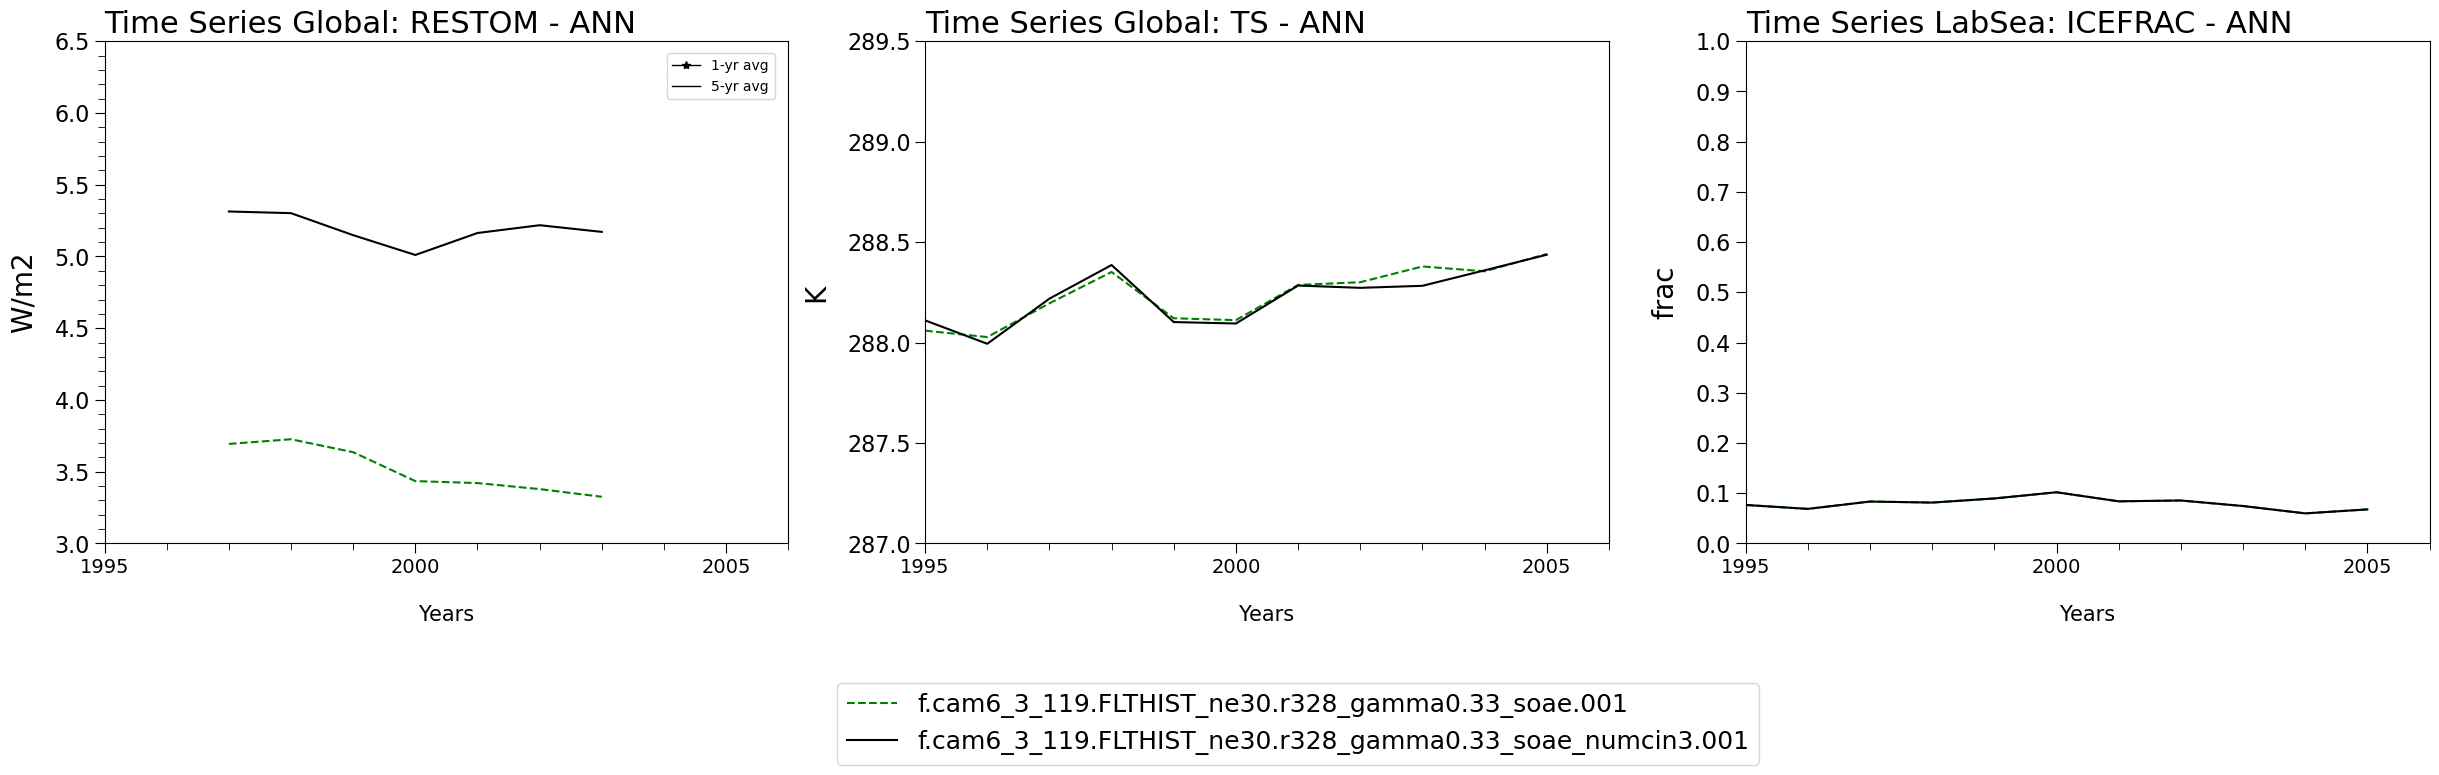

In [28]:
%matplotlib inline

import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import matplotlib.ticker as ticker
from matplotlib.ticker import MultipleLocator
from matplotlib.lines import Line2D

fig = plt.figure(figsize=(30,15))

# Change the layout/number of subplots based off number of variables desired
rows = 2
cols = 3
gs = fig.add_gridspec(rows, cols, hspace=.3, wspace=.2)

# Rough subset for Lab Sea
w = -63.5+360
e = -47.5+360
s = 53.5
n = 65.5
subset = {"s":s,"n":n,"e":e,"w":w}

# Add more colors as needed for number of test cases
# ** Baseline is already added as green dashed line in plotting function **
# matplotlib colors here: https://matplotlib.org/stable/gallery/color/named_colors.html
colors = ["k", "aqua", "orange", "b", "magenta", "goldenrod", "slategrey", "rosybrown"]

# Setup plotting
#---------------

# Loop over variables:
for i,var in enumerate(ts_var_list):
        
    print("Plotting variable:",var)
        
    if var == "RESTOM":
        ax = plt.subplot(gs[0, 0])
    if var == "TS":
        ax = plt.subplot(gs[0, 1])
    if var == "ICEFRAC":
        ax = plt.subplot(gs[0, 2])

    # Grab baseline case:
    #--------------------

    if var == "RESTOM":            
        avg_base_FSNT,yrs_base,unit = _data_calcs(data_ts_loc,'FSNT')
        avg_base_FLNT,_,_ = _data_calcs(data_ts_loc,"FLNT")
        if len(yrs_base) < 5:
            print(f"Not a lot of climo years for {data_name}, only doing 1-yr avg for RESTOM...")
            FSNT_base = avg_base_FSNT
            FLNT_base = avg_base_FLNT
        else:
            FSNT_base = avg_base_FSNT.rolling(time=60,center=True).mean()
            FLNT_base = avg_base_FLNT.rolling(time=60,center=True).mean()

        avg_base = FSNT_base - FLNT_base
            
    if (var == "TS" or var == "SST"):
        avg_base,yrs_base,unit = _data_calcs(data_ts_loc,var)
                
    if var == "ICEFRAC":
        avg_base,yrs_base,unit = _data_calcs(data_ts_loc,var,subset)
    
    # Get int of years for plotting on x-axis
    yrs_base_int = yrs_base.astype(int)

    # Create yearly averages
    vals_base = [avg_base.sel(time=i).mean() for i in yrs_base]
        
    # Plot baseline data
    color_dict = {"color":"g","marker":"--"}
    ax = ts_plot(ax, data_name, vals_base, yrs_base_int, unit, color_dict)

    # Loop over test cases:
    #----------------------
    # Create lists to hold all sets of years (for each case) and
    # sets of var data (for each case)
    vals_cases = []
    yrs_cases = []
    for case_idx, case_name in enumerate(case_names):

        if var == "RESTOM":
            avg_case_FSNT,yrs_case,unit = _data_calcs(case_ts_locs[case_idx],'FSNT')
            avg_case_FLNT,_,_ = _data_calcs(case_ts_locs[case_idx],"FLNT")
            if len(yrs_case) < 5:
                print(f"Not a lot of climo years for {case_name}, only doing 1-yr avg for RESTOM...")
                FSNT_case = avg_case_FSNT
                FLNT_case = avg_case_FLNT
                color_dict = {"color":colors[case_idx],"marker":"-*"}
            else:
                FSNT_case = avg_case_FSNT.rolling(time=60,center=True).mean()
                FLNT_case = avg_case_FLNT.rolling(time=60,center=True).mean()
                color_dict = {"color":colors[case_idx],"marker":"-"}

            avg_case = FSNT_case - FLNT_case

        if var == "TS":
            avg_case,yrs_case,unit = _data_calcs(case_ts_locs[case_idx],var)
            color_dict = {"color":colors[case_idx],"marker":"-"}
                
        if var == "ICEFRAC":
            avg_case,yrs_case,unit = _data_calcs(case_ts_locs[case_idx],var,subset)
            color_dict = {"color":colors[case_idx],"marker":"-"}
                
        # Get yearly averages for all available years
        vals_case = [avg_case.sel(time=i).mean() for i in yrs_case]
        vals_cases.append(vals_case)
            
        # Get int of years for plotting on x-axis
        yrs_case_int = yrs_case.astype(int)
        yrs_cases.append(yrs_case_int)
        
        # Add case to plot (ax)
        ax = ts_plot(ax, case_name, vals_case, yrs_case_int, unit, color_dict)

    # End for (case names)

    # Get variable details
    ax = plot_var_details(ax, var, vals_cases, vals_base)

    #Grab all unique years and find min/max years
    uniq_yrs = sorted(x for v in yrs_cases for x in v)
    max_year = int(max(uniq_yrs))
    min_year = int(min(uniq_yrs))

    last_year = max_year - max_year % 5
    if (max_year > 5) and (last_year < max_year):
        last_year += 5

    first_year = min_year - min_year % 5
    if min_year < 5:
        first_year = 0

    ax.set_xlim(first_year, last_year)
    ax.set_xlabel("Years",fontsize=15,labelpad=20)
    # Set the x-axis plot limits
    # to guarantee data from all cases (including baseline) are on plot
    ax.set_xlim(min_year, max_year+1)

    # x-axis ticks and numbers
    if max_year-min_year > 120:
        ax.xaxis.set_major_locator(MultipleLocator(20))
        ax.xaxis.set_minor_locator(MultipleLocator(10))
    if 10 <= max_year-min_year <= 120:
        ax.xaxis.set_major_locator(MultipleLocator(5))
        ax.xaxis.set_minor_locator(MultipleLocator(1))
    if 0 < max_year-min_year < 10:
        ax.xaxis.set_major_locator(MultipleLocator(1))
        ax.xaxis.set_minor_locator(MultipleLocator(1))
        
    # End for (case loop)
# End for (variables loop)

# Set up legend
# Gather labels based on case names and plotted line format (color, style, etc)
lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines[:case_names_len+1], labels[:case_names_len+1],
            loc="center left",fontsize=18,
            bbox_to_anchor=(0.365, 0.4,.02,.05)) #bbox_to_anchor(x0, y0, width, height)

fig.show()

#plt.savefig("TimeSeries_ANN.png", facecolor='w',bbox_inches="tight")